# Q learning vs Double Q learning

### GridWorld 

Consider the small grid world as shown in the figure below. 

![alt text](gridworld.png "Title")

Each state has 4 actions, corresponding to the directions the agent can go (agent can try and move up, down, left, right)

The starting state is in the lower left position and the goal state is in the upper right. 

Each time the agent selects an action that walks off the grid, the agent stays in the same state. 

For each non-terminating step, the agent receives a random reward of −12 or +10 with equal probability. 

Once it arrives to a goal state it gets a reward +5 and ends an episode. 

In [1]:
#create visualization for gridworld

import numpy as np
import matplotlib.pyplot as plt
import itertools
from tqdm import tqdm

def plot_world(World):
    # ------------------
    Ly, Lx = World.shape

    fig, ax = plt.subplots(1,1, figsize=(5,5))
    im = ax.imshow(World, extent=(0, Lx, Ly, 0), cmap=plt.cm.Blues)

    #display ticks
    ax.set_xticks(np.arange(Lx))
    ax.set_yticks(np.arange(Ly))
    
    #create text annotations
    goal = np.where(np.logical_or( World > 0.0, World < -1.0))
    for i in range(Lx):
        for j in range(Ly):
            if np.logical_and(goal[0]==j,goal[1]==i).any():
                print('j', j)
                print('i', i)
                text = ax.text(i+0.5,j+0.5, 'G={}'.format(World[j,i]), ha="center", va="center", color="white")
            else:
                pass

    plt.show()

Matrix representation of the gridworld: 
[[0. 0. 5.]
 [0. 0. 0.]
 [0. 0. 0.]]
Visual representation of the gridworld:
j 0
i 2


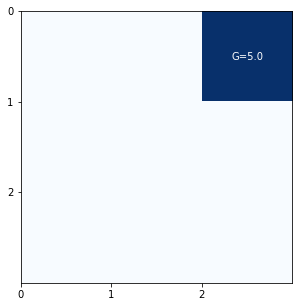

In [2]:
Lx = 3
Ly = 3

goal = [(Ly-3,Lx-1)]
rewards = [5]

World = np.zeros((Ly,Lx))
for g, r in zip(goal, rewards):
    World[g] = r


print("Matrix representation of the gridworld: ")
print(World)

print("Visual representation of the gridworld:")
plot_world(World)

## Gridworld environment

In [3]:
class GridWorldEnv():
    def __init__(self, World, start, end):
        """
        Defines a GridWorld with start and end sites.
        """
        # Reads the World shape
        self.Ly, self.Lx = World.shape
        self.World = World
        
        # Reads the position of start and end
        self.start = start
        self.end = end
        
        # Keeps track of current state
        self.current_state = self.start
        
        # Keeps track of terminal state
        self.done = False
        
    def reset(self):
        """
        Resets the GridWorld to the starting position.
        """
        # Reset the environment to initial state
        self.current_state = self.start
        self.done = False
        
    def step(self, A):
        """
        Evolves the environment given action A and current state.
        """
        # Check if action A is in proper set (right, up, left, down)
        assert A in np.array([[1,0],[0,1],[-1,0],[0,-1]])
        S = self.current_state
        S_new = S + A

       
        #receives a random reward of −12 or +10 with equal probability
        prob = 0.5
        unif = np.random.rand()
        if unif < prob: 
            reward = 10
        else:
            reward = -12

        # If I go out of the world, I stay still
        if ( ((S_new[0] == self.Ly) or np.any(S_new == -1)) or (S_new[1] == self.Lx)):
            S_new = S  
        elif np.all(S_new == self.end):
            self.done = True   
        
        # Save in memory new position
        self.current_state = S_new
            
        return S_new, reward, self.done

## Q Learning



![alt text](q_learning.png "Title")

In [4]:
class Qlearning_TDControl():
    def __init__(self, 
                 space_size, 
                 action_size, 
                 gamma):
        """
        Calculates optimal policy using Q Learning
        Evaluates Q-value for (S,A) pairs, using one-step updates.
        """            
        # the discount factor
        self.gamma = gamma
        # size of system
        self.space_size = space_size # as tuple
        self.action_size = action_size

        # where to save returns
        self.Qvalues = np.zeros( (*self.space_size, self.action_size) )
    
    def get_action_epsilon_greedy(self, s, epsilon):
        """
        Chooses action at random using an epsilon-greedy policy wrt the current Q(s,a).
        """
        ran = np.random.rand()
        
        if ran < epsilon:
            # probability is uniform for all actions!
            prob_actions = np.ones(self.action_size) / self.action_size 
        
        else:
            # I find the best Qvalue
            best_value = np.max(self.Qvalues[ (*s,) ])
            
            # There could be actions with equal value! 
            
            best_actions = ( self.Qvalues[ (*s,) ] == best_value )
            # best_actions is 
            # *True* if the value is equal to the best (possibly ties)
            # *False* if the action is suboptimal
            prob_actions = best_actions / np.sum(best_actions)
            
        # take one action from the array of actions with the probabilities as defined above.
        a = np.random.choice(self.action_size, p=prob_actions)
        return a 
    
    def single_step_update(self, s, a, r, new_s, step_size, done):
        """
        Uses a single step to update the values, using Temporal Difference for Q values.
        Uses the BEST (evaluated) action in the new state <- Q(S_new, A*) = max_A Q(S_new, A).
        """
        if done:
            # deltaQ = R - Q(s,a)             
            deltaQ = (r + 0 - self.Qvalues[ (*s, a) ])
        
        else:
            # deltaQ = R + gamma*max_act Q(new_s, act)- Q(s,a)
            maxQ_over_actions = np.max(self.Qvalues[ (*new_s,) ])
            deltaQ = (r + self.gamma * maxQ_over_actions - self.Qvalues[ (*s,a) ])
        
        self.Qvalues[ (*s, a) ] += step_size * deltaQ  
        
    def greedy_policy(self):
        a = np.argmax(self.Qvalues, axis = 2)
        return a   

## Double Q Learning

Maintain two Q-value functions $Q_1 (s,a)$ and $Q_2 (s, a)$, each one gets update from the other for the next state.
The update consists of finding the action a* that maximises $Q_1$ in the next state, then use a* to get the value of $Q_2 (s’, a*)$ in order to update $Q_1 (s, a)$.

![alt text](double_q_learning.png "Title")

In [5]:
class DoubleQlearning_TDControl():
    def __init__(self, 
                 space_size, 
                 action_size, 
                 gamma):
        """
        Calculates optimal policy using Double Q Learning
        Evaluates Q-value for (S,A) pairs, using one-step updates.
        """            
        # the discount factor
        self.gamma = gamma
        # size of system
        self.space_size = space_size # as tuple
        self.action_size = action_size

        # where to save returns
        self.Qvalues_1 = np.zeros( (*self.space_size, self.action_size) )
        self.Qvalues_2 = np.zeros( (*self.space_size, self.action_size) )
    
    def get_action_epsilon_greedy(self, s, epsilon):
        """
        Chooses action at random using an epsilon-greedy policy Q1 + Q2.
        """
        ran = np.random.rand()
        
        if ran < epsilon:
            # probability is uniform for all actions!
            prob_actions = np.ones(self.action_size) / self.action_size 
        
        else:
            # Find the maximum of Q1 + Q2
            Q1_and_Q2 = self.Qvalues_1[ (*s,) ] + self.Qvalues_2[ (*s,) ]
            best_value = np.max(Q1_and_Q2)
            
            # There could be actions with equal value! 
            best_actions = (Q1_and_Q2 == best_value )
            
            # best_actions is 
            # *True* if the value is equal to the best (possibly ties)
            # *False* if the action is suboptimal
            prob_actions = best_actions / np.sum(best_actions)

        # take one action from the array of actions with the probabilities as defined above.
        a = np.random.choice(self.action_size, p=prob_actions)
        return a
    
    def single_step_update_Q1(self, s, a, r, new_s, step_size, done):
        """
        Uses a single step to update the values
        Consists of finding the action a* that maximises Q1 in the next state, 
        then use a* to get the value of Q2(s’, a*) in order to update Q1(s, a).
        """
        if done:
            # deltaQ = R - Q(s,a)             
            deltaQ = (r + 0 - self.Qvalues_1[ (*s, a) ])
            
        else:
            a_star_idx = np.argmax(self.Qvalues_1[ (*new_s, a) ])
            deltaQ = (r + self.gamma * self.Qvalues_2[ (*new_s, a_star_idx) ] - self.Qvalues_1[ (*s, a) ])   
        
        self.Qvalues_1[ (*s, a) ] += step_size * deltaQ
        
    def single_step_update_Q2(self, s, a, r, new_s, step_size, done):
        """
        Uses a single step to update the values
        Consists of finding the action a* that maximises Q2 in the next state, 
        then use a* to get the value of Q1(s’, a*) in order to update Q2(s, a).
        """
        if done:
            # deltaQ = R - Q(s,a)             
            deltaQ = (r + 0 - self.Qvalues_2[ (*s, a) ])
            
        else:
            a_star_idx = np.argmax(self.Qvalues_2[ (*new_s, a) ])
            deltaQ = (r + self.gamma * self.Qvalues_1[ (*new_s, a_star_idx) ] - self.Qvalues_2[ (*s, a) ])   
        
        self.Qvalues_2[ (*s, a) ] += step_size * deltaQ
        
    def greedy_policy_Q1(self):
        a = np.argmax(self.Qvalues_1, axis = 2)
        return a  
    
    def greedy_policy_Q2(self):
        a = np.argmax(self.Qvalues_2, axis = 2)
        return a  

### Start

In [6]:
#algorithm parameters
env = GridWorldEnv(World, start=[2,0], end=[0,2])
Actions  = np.array([[1,0],[-1,0],[0,1],[0,-1]])


space_size = World.shape
action_size = 4
gamma = 0.95
num_episodes = 1000
num_experiments = 100

#step_size = 1/(n(s,a)**0.8)
# where n(s,a) = number of updates for each state action pair

#epsilon = 1/np.sqrt(n(s))
#where n(s) = number of visits for each state

#design step size and epsilon to be decreasing = explore more and take larger steps at the beginning because we
#don't know much about the world yet, but as time goes by, we will explore less and focus on the goal

### Implement Q-learning

In [7]:
%%time
# Q-Learning Control

n_experiments = num_experiments

num_steps_Q_mother_list = []
performance_traj_Q_mother_list = []
Q_values_mother_list = []

for i in tqdm(range(n_experiments)):
    n_episodes = num_episodes

    # Initialize 
    QLearning = Qlearning_TDControl(space_size = space_size, action_size = action_size, gamma = gamma)

    performance_traj_Q = np.zeros(n_episodes)

    # RUN OVER EPISODES

    #contains number of steps per episode
    num_steps_per_episode_Q_list = []

    #contains the number of visits for each state
    iterable = [0,1,2]
    state_dict = {}
    for item in itertools.product(iterable, repeat=2):
        state_dict[item] = 0

    #contains the number of visits for each state and action
    state_ = []
    for item in itertools.product(iterable, repeat=2):
        state_.append(item)

    state_action_dict = {}
    for states_ in state_:
        for actions_ in [0,1,2,3]:
            states_actions_ = states_ + (actions_,)
            state_action_dict[states_actions_] = 0

    for i in range(n_episodes):
        done = False

        env.reset()
        s = env.current_state
        state_dict[tuple(s)] += 1

        epsilon = 1/np.sqrt(state_dict[tuple(s)])

        a = QLearning.get_action_epsilon_greedy(s, epsilon)   
        act = Actions[a]

        num_steps_Q = 0
        while not done:

            # Evolve one step
            new_s, r, done = env.step(act)

            # Keeps track of performance for each episode
            performance_traj_Q[i] += r

            # Choose new action index
            state_dict[tuple(new_s)] += 1
            epsilon = 1/np.sqrt(state_dict[tuple(new_s)])

            new_a = QLearning.get_action_epsilon_greedy(new_s, epsilon)
            # (Corresponding action to index)
            act = Actions[new_a]

            # Single update with (S, A, R', S')
            state_action_dict[(*s, a)] += 1
            step_size = 1/(state_action_dict[(*s, a)] **0.8)
            QLearning.single_step_update(s, a, r, new_s, step_size, done)

            a = new_a
            s = new_s  

            num_steps_Q += 1
        num_steps_per_episode_Q_list.append(num_steps_Q)  

    Qvalues_QLearning = QLearning.Qvalues

    num_steps_Q_mother_list.append(num_steps_per_episode_Q_list)
    performance_traj_Q_mother_list.append(performance_traj_Q)
    Q_values_mother_list.append(Qvalues_QLearning)

100%|██████████| 10/10 [01:45<00:00, 10.56s/it]

Wall time: 1min 45s


### Implement Double-Q Learning

In [8]:
%%time
#Double Q-Learning Control

n_experiments = num_experiments

num_steps_DoubleQ_mother_list = []
performance_traj_DoubleQ_mother_list = []
DoubleQ_values_1_mother_list = []
DoubleQ_values_2_mother_list = []

for i in tqdm(range(n_experiments)):
    n_episodes = num_episodes

    # Initialize 
    DoubleQLearning = DoubleQlearning_TDControl(space_size = space_size, action_size = action_size, gamma = gamma)

    performance_traj_DoubleQ = np.zeros(n_episodes)

    # RUN OVER EPISODES

    #contains number of steps per episode
    num_steps_per_episode_DoubleQ_list = []

    #contains the number of visits for each state
    iterable = [0,1,2]
    state_dict = {}
    for item in itertools.product(iterable, repeat=2):
        state_dict[item] = 0

    #contains the number of visits for each state and action
    state_ = []
    for item in itertools.product(iterable, repeat=2):
        state_.append(item)

    state_action_dict_Q1 = {}
    for states_ in state_:
        for actions_ in [0,1,2,3]:
            states_actions_Q1 = states_ + (actions_,)
            state_action_dict_Q1[states_actions_Q1] = 0
            
    state_action_dict_Q2 = {}
    for states_ in state_:
        for actions_ in [0,1,2,3]:
            states_actions_Q2 = states_ + (actions_,)
            state_action_dict_Q2[states_actions_Q2] = 0

    for i in range(n_episodes):
        done = False

        env.reset()
        s = env.current_state
        state_dict[tuple(s)] += 1

        epsilon = 1/np.sqrt(state_dict[tuple(s)])

        a = DoubleQLearning.get_action_epsilon_greedy(s, epsilon)
        act = Actions[a]

        num_steps_DoubleQ = 0
        while not done:
            # Evolve one step
            new_s, r, done = env.step(act)

            # Keeps track of performance for each episode
            performance_traj_DoubleQ[i] += r

            # Choose new action index
            state_dict[tuple(new_s)] += 1
            epsilon = 1/np.sqrt(state_dict[tuple(new_s)])

            new_a = DoubleQLearning.get_action_epsilon_greedy(new_s, epsilon)
            # (Corresponding action to index)
            act = Actions[new_a]

            # Single update with (S, A, R', S')
            if (np.random.rand() < 0.5):
                state_action_dict_Q1[(*s, a)] += 1
                step_size = 1/(state_action_dict_Q1[(*s, a)] ** 0.8)
                DoubleQLearning.single_step_update_Q1(s, a, r, new_s, step_size, done)
            else:
                state_action_dict_Q2[(*s, a)] += 1
                step_size = 1/(state_action_dict_Q2[(*s, a)] ** 0.8)
                DoubleQLearning.single_step_update_Q2(s, a, r, new_s, step_size, done)

            a = new_a      
            s = new_s

            num_steps_DoubleQ += 1
        num_steps_per_episode_DoubleQ_list.append(num_steps_DoubleQ)   

    DoubleQvalues_QLearning_1 = DoubleQLearning.Qvalues_1
    DoubleQvalues_QLearning_2 = DoubleQLearning.Qvalues_2
    
    num_steps_DoubleQ_mother_list.append(num_steps_per_episode_DoubleQ_list)
    performance_traj_DoubleQ_mother_list.append(performance_traj_DoubleQ)
    DoubleQ_values_1_mother_list.append(DoubleQvalues_QLearning_1)
    DoubleQ_values_2_mother_list.append(DoubleQvalues_QLearning_2)

100%|██████████| 10/10 [05:06<00:00, 30.65s/it]

Wall time: 5min 6s


### Rewards

In [24]:
#take the average reward per step for each episode by dividing the rewards with the number of
#steps taken in that episode
ave_reward_per_step_list_DoubleQ = []
for i in range(num_experiments):
    ave_reward_per_step_DoubleQ = np.array(performance_traj_DoubleQ_mother_list)[i] / np.array(num_steps_DoubleQ_mother_list)[i]
    ave_reward_per_step_list_DoubleQ.append(ave_reward_per_step_DoubleQ)

#for each average reward per step for each episode, take the average over 5 experiments
ave_rewards_DoubleQ = []
for i in range(num_episodes):
    ave_DoubleQ = np.array(ave_reward_per_step_list_DoubleQ)[:,i].mean()
    ave_rewards_DoubleQ.append(ave_DoubleQ)

In [25]:
ave_reward_per_step_list_Q = []
for i in range(num_experiments):
    ave_reward_per_step_Q = np.array(performance_traj_Q_mother_list)[i] / np.array(num_steps_Q_mother_list)[i]
    ave_reward_per_step_list_Q.append(ave_reward_per_step_Q)
    
ave_rewards_Q = []
for i in range(num_episodes):
    ave_Q = np.array(ave_reward_per_step_list_Q)[:,i].mean()
    ave_rewards_Q.append(ave_Q)

### Take average rewards per step then take average over experiments

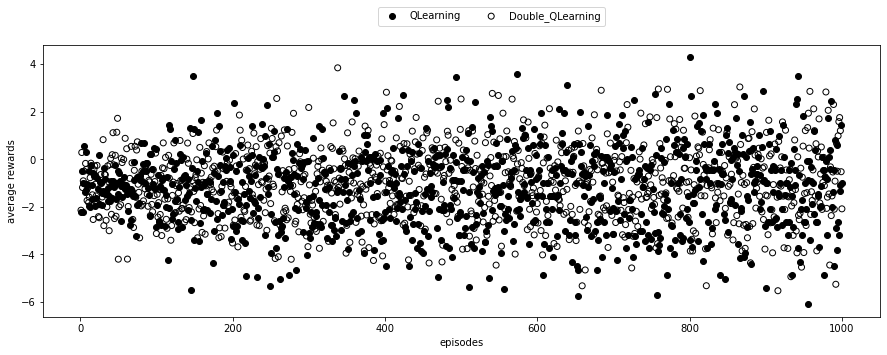

In [29]:
fig, ax = plt.subplots(figsize=(15,5))
ax.scatter(np.arange(1, n_episodes+1), ave_rewards_Q, label='QLearning', color='black')
ax.scatter(np.arange(1, n_episodes+1), ave_rewards_DoubleQ, label='Double_QLearning', facecolors='none', edgecolors='black')

plt.xlabel('episodes')
plt.ylabel('average rewards')

fig.legend(bbox_to_anchor = (0.65, 1), ncol=2)

plt.show()

### Take sum of rewards per episode (averaged over experiments)

In [34]:
ave_rewards_wout_per_step_DoubleQ = []
for i in range(num_episodes):
    ave_wout_step_DoubleQ = np.array(performance_traj_DoubleQ_mother_list)[:,i].mean()
    ave_rewards_wout_per_step_DoubleQ.append(ave_wout_step_DoubleQ)
    
ave_rewards_wout_per_step_Q = []
for i in range(num_episodes):
    ave_wout_step_Q = np.array(performance_traj_Q_mother_list)[:,i].mean()
    ave_rewards_wout_per_step_Q.append(ave_wout_step_Q)

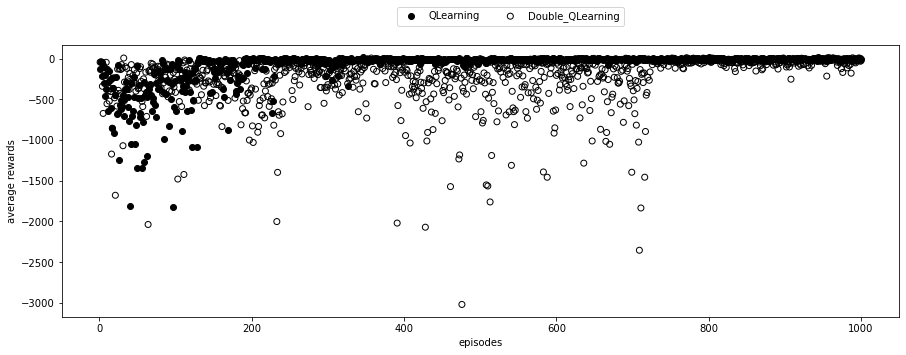

In [35]:
fig, ax = plt.subplots(figsize=(15,5))
ax.scatter(np.arange(1, n_episodes+1), ave_rewards_wout_per_step_Q, label='QLearning', color='black')
ax.scatter(np.arange(1, n_episodes+1), ave_rewards_wout_per_step_DoubleQ, label='Double_QLearning', facecolors='none', edgecolors='black')

plt.xlabel('episodes')
plt.ylabel('average rewards')

fig.legend(bbox_to_anchor = (0.65, 1), ncol=2)

plt.show()

### Snapshot of a policy

In [30]:
def plot_world_values_policy(World, Values, Policy):
    # ------------------
    Ly, Lx = World.shape

    fig, ((ax), (ax2), (ax3)) = plt.subplots(3,1, figsize=(15,15))
    im = ax.imshow(World, extent=(0, Lx, Ly, 0), cmap=plt.cm.Blues)

    # We want to show all ticks...
    ax.set_xticks(np.arange(Lx))
    ax.set_yticks(np.arange(Ly))

    goal = np.where(np.logical_or( World > 0.0, World < -1.0))
    # Loop over data dimensions and create text annotations.
    for i in range(Lx):
        for j in range(Ly):
            if np.logical_and(goal[0]==j,goal[1]==i).any():
                text = ax.text(i+0.5,j+0.5, 'G={}'.format(World[j,i]), ha="center", va="center", color="white")
            else:
                pass

    im2 = ax2.imshow(Values, extent=(0, Lx, Ly, 0), cmap=plt.cm.Blues)

    # We want to show all ticks...
    ax2.set_xticks(np.arange(Lx))
    ax2.set_yticks(np.arange(Ly))
    
    goal = np.where(np.logical_or( World > 0.0, World < -1.0))
    # Loop over data dimensions and create text annotations.
    for i in range(Lx):
        for j in range(Ly):
            if np.logical_and(goal[0]==j, goal[1]==i).any():
                text = ax2.text(i+0.5,j+0.5, 'G={}'.format(World[j,i]), ha="center", va="center", color="white")
                text = ax3.text(i+0.5,j+0.5, 'G={}'.format(World[j,i]), ha="center", va="center", color="white")
            else:
                text = ax2.text(i+0.5, j+0.5, '{:.2f}'.format(Values[j, i]), ha="center", va="center", color="white")
    
    im3 = ax3.imshow(Values, extent=(0, Lx, Ly, 0), cmap=plt.cm.Blues)
    
    ax3.set_xticks(np.arange(Lx))
    ax3.set_yticks(np.arange(Ly))
    
    X = np.arange(Lx)
    Y = np.arange(Ly)

    for gx, gy in zip(goal[0],goal[1]) :
        Policy[gx,gy] = 0
        
    U, V = Policy[:,:,1], -Policy[:,:,0]
    q = ax3.quiver(X+0.5, Y+0.5, U, V, color="black")

    plt.show()

### Q learning

[[-3.5118498  -4.10031629  0.        ]
 [-4.11240442 -2.02003668 -1.72401342]
 [-4.89370746 -4.05536293 -3.19301261]]


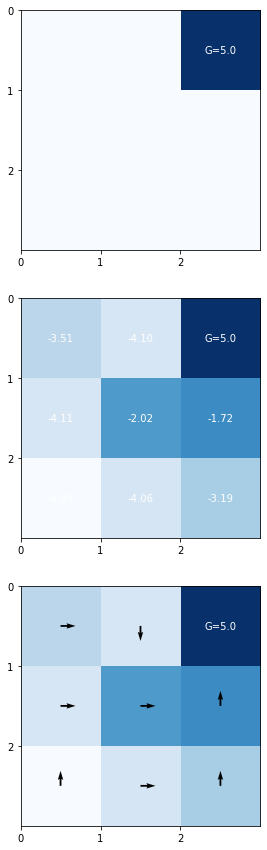

In [31]:
# Optimal policy for QLearning as index actions
optimal_policy_index_QLearning = QLearning.greedy_policy()

# Optimal policy for QLearning as arrows for plots
optimal_policy_arrows_QLearning = np.zeros( (*World.shape, 2) )
optimal_policy_arrows_QLearning[:,:] = Actions[ optimal_policy_index_QLearning ]

optimal_Qvalue_action_QLearning = np.zeros((optimal_policy_index_QLearning.shape))

Lx, Ly = World.shape

for i in range(Lx):
    for j in range(Ly):
        optimal_Qvalue_action_QLearning[i,j] = Qvalues_QLearning[i,j,optimal_policy_index_QLearning[i,j]]

print(optimal_Qvalue_action_QLearning)
plot_world_values_policy(World, optimal_Qvalue_action_QLearning, optimal_policy_arrows_QLearning)

### Double Q Learning

[[-3.5118498  -4.10031629  0.        ]
 [-4.11240442 -2.02003668 -1.72401342]
 [-4.89370746 -4.05536293 -3.19301261]]


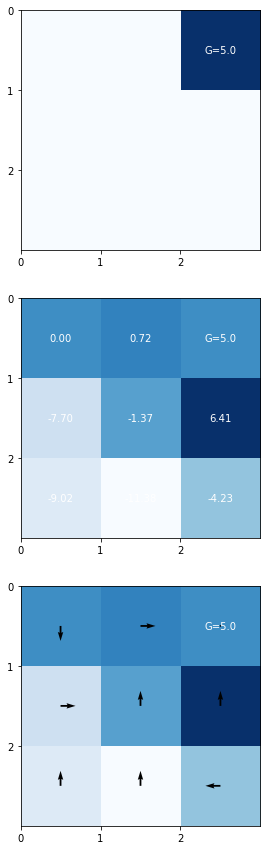

In [32]:
# Optimal policy for QLearning as index actions
optimal_policy_index_DoubleQLearning = DoubleQLearning.greedy_policy_Q1()

# Optimal policy for QLearning as arrows for plots
optimal_policy_arrows_DoubleQLearning = np.zeros( (*World.shape, 2) )
optimal_policy_arrows_DoubleQLearning[:,:] = Actions[ optimal_policy_index_DoubleQLearning ]

optimal_Qvalue_action_DoubleQLearning = np.zeros((optimal_policy_index_DoubleQLearning.shape))

Lx, Ly = World.shape

for i in range(Lx):
    for j in range(Ly):
        optimal_Qvalue_action_DoubleQLearning[i,j] = DoubleQvalues_QLearning_1[i,j,optimal_policy_index_DoubleQLearning[i,j]]

print(optimal_Qvalue_action_QLearning)
plot_world_values_policy(World, optimal_Qvalue_action_DoubleQLearning, optimal_policy_arrows_DoubleQLearning)

[[-3.5118498  -4.10031629  0.        ]
 [-4.11240442 -2.02003668 -1.72401342]
 [-4.89370746 -4.05536293 -3.19301261]]


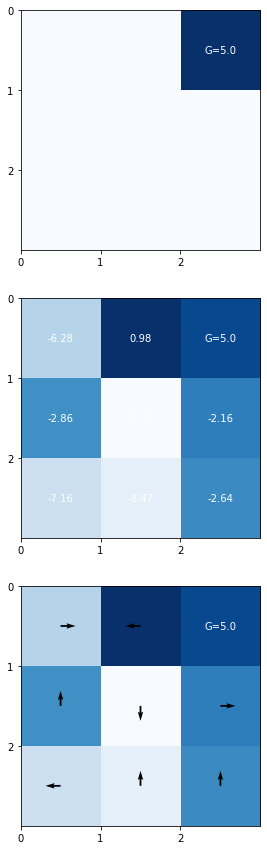

In [33]:
# Optimal policy for QLearning as index actions
optimal_policy_index_DoubleQLearning = DoubleQLearning.greedy_policy_Q2()

# Optimal policy for QLearning as arrows for plots
optimal_policy_arrows_DoubleQLearning = np.zeros( (*World.shape, 2) )
optimal_policy_arrows_DoubleQLearning[:,:] = Actions[ optimal_policy_index_DoubleQLearning ]

optimal_Qvalue_action_DoubleQLearning = np.zeros((optimal_policy_index_DoubleQLearning.shape))

Lx, Ly = World.shape

for i in range(Lx):
    for j in range(Ly):
        optimal_Qvalue_action_DoubleQLearning[i,j] = DoubleQvalues_QLearning_2[i,j,optimal_policy_index_DoubleQLearning[i,j]]

print(optimal_Qvalue_action_QLearning)
plot_world_values_policy(World, optimal_Qvalue_action_DoubleQLearning, optimal_policy_arrows_DoubleQLearning)